# Fraud detection of account addresses on Ethereum blockchain

## Data Visualization

### Imports

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import torch

from utils import *

### Load

In [15]:
SEED = 104
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

df = pd.read_csv('data/mettl/train_agg.csv')
test_df = pd.read_csv('data/mettl/test_agg.csv')

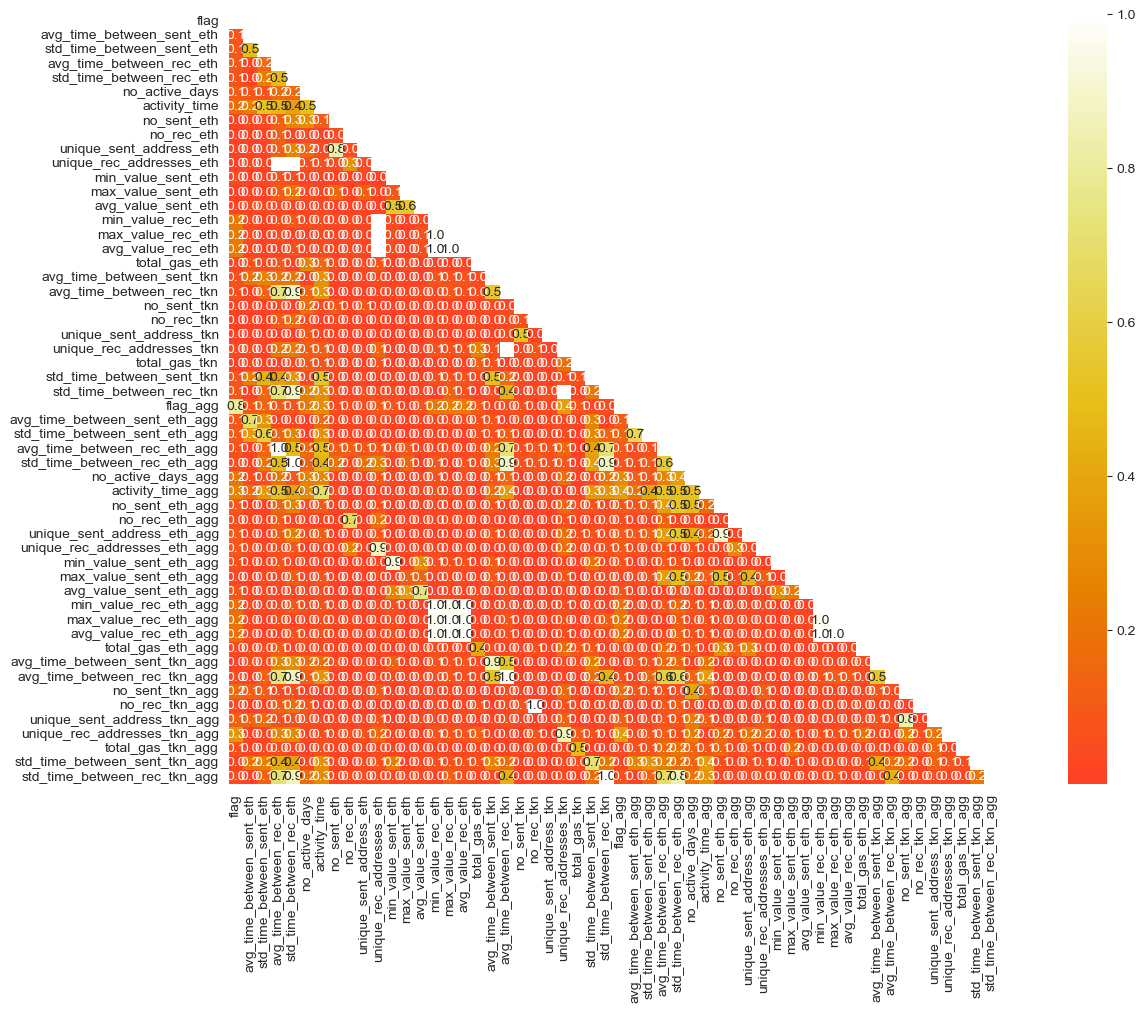

In [16]:
df_feat = df.iloc[:, 1:]
corr = df_feat.corr().abs()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18, 10))
    sns.heatmap(corr, mask=mask, annot=True, cmap='CMRmap', center=0, square=True, fmt='.1f')

Some features are highly correlated and we can drop either ones with lower correlation with flag (target).

In [17]:
corr_th = 0.9
pairs = find_highly_correlated(corr.iloc[1:, 1:], threshold=corr_th)
must_delete = find_least_correlated_with(pairs, corr, 'flag')
df_feat.drop(must_delete, axis=1, inplace=True)
test_df.drop(must_delete, axis=1, inplace=True)

Dataset might not be balanced (positive and negative cases), hence we resample negative cases randomly to match the number of positive cases.

In [18]:
pos_samples = df_feat[df_feat.flag == 1]
neg_samples = df_feat[df_feat.flag == 0].sample(len(pos_samples), random_state=SEED)
data = pd.concat([pos_samples, neg_samples], axis=0, sort=False, ignore_index=True)

Then, we also replace any `NaN` value in `X` with average of its column.

In [19]:
for key in data.columns:
    if key == 'flag':
        continue
    m = data[key].mean()
    data[key] = data[key].fillna(m)
    test_df[key] = test_df[key].fillna(m)
X = data.iloc[:, 1:]
y = data.flag

## Dataset Preparation

### Imports

In [20]:
from sklearn.model_selection import KFold

### Cross-validation

We use `k`-folds cross-validation, i.e., split dataset to `k` random folds and each fold will be used exactly once as a validation set while remaining `k-1` folds are used as training set.

In [21]:
k = 8
kf = KFold(n_splits=k, shuffle=True, random_state=SEED)

## Training

### Imports

In [22]:
from pycm import ConfusionMatrix
import tqdm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

### Training

In [23]:
ada_params = {'learning_rate': 0.04, 'n_estimators': 400, 'random_state': SEED, 'base_estimator': DecisionTreeClassifier(criterion='log_loss', max_depth=5, random_state=SEED)}
best_cm = None
worst_cm = None
cm_list = []
best_model = None
# b_scaler = None
scaler = StandardScaler().fit(data.iloc[:, 1:])
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    data_train, data_val = data.iloc[train_idx], data.iloc[val_idx]
    X_train, y_train = data_train.iloc[:, 1:], data_train.flag
    X_val, y_val = data_val.iloc[:, 1:], data_val.flag
    # scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    ada_model = AdaBoostClassifier(**ada_params)
    ada_model.fit(X_train, y_train)
    cm = ConfusionMatrix(actual_vector=y_val.values, predict_vector=ada_model.predict(X_val))
    cm.relabel({0: 'Non-fraud', 1: 'Fraud'})
    cm_list.append(cm)
    if best_cm is None:
        best_cm = cm
        worst_cm = cm
    else:
        if cm.Overall_ACC > best_cm.Overall_ACC:
            best_cm = cm
            best_model = ada_model
            # b_scaler = scaler
        elif cm.Overall_ACC < worst_cm.Overall_ACC:
            worst_cm = cm
temp = {'accuracy': [], 'F1': [], 'precision': [], 'recall': []}

accuracy:  0.8499
F1:  0.8497
precision:  0.8500
recall:  0.8500


<AxesSubplot:title={'center':'Best Fold'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

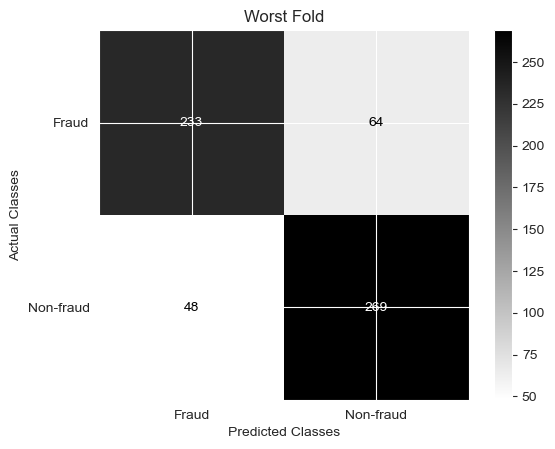

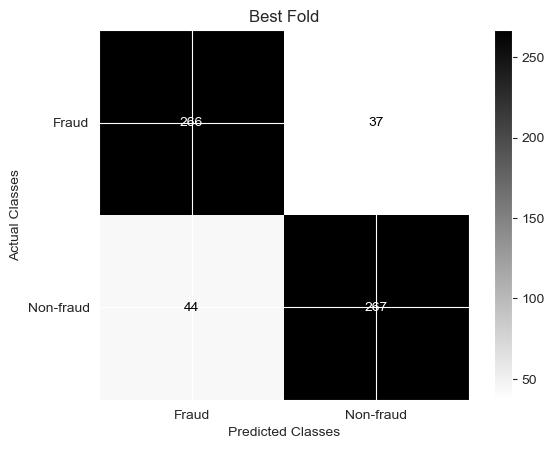

In [24]:
for cm in cm_list:
    stat = cm.overall_stat
    temp['accuracy'].append(stat['Overall ACC'])
    temp['F1'].append(stat['F1 Macro'])
    temp['precision'].append(stat['PPV Macro'])
    temp['recall'].append(stat['TPR Macro'])
for k in temp.keys():
    print(f'{k}: {np.mean(temp[k]): .4f}')
worst_cm.plot(title='Worst Fold', number_label=True)
best_cm.plot(title='Best Fold', number_label=True)

In [25]:
X_test = test_df.iloc[:, 1:]
X_test = scaler.transform(X_test)
y_pred = best_model.predict(X_test)
test_res = pd.concat([test_df.account, pd.DataFrame(y_pred)], axis=1, ignore_index=True)
test_res = test_res.rename({0: 'account', 1: 'flag'}, axis=1)
test_res.to_csv('data/mettl/ada_pred.csv', index=False)